In [1]:
import os
import datetime

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle

from sklearn.model_selection import train_test_split

import warnings
warnings.filterwarnings("ignore")

def f_bits2array(bits):
  return [b*2**p for p,b in enumerate(np.flip(bits)) if b!=0]

def f_class_weights(yy):
  yy_labels,yy_counts = np.unique(yy,return_counts=True,axis=0)
  cc_weights = {i:0 for i in range(np.max(yy.ravel())+1)}
  yy_weights = len(yy)/(len(yy_labels)*yy_counts)
  cc_weights.update({yy_labels[i][0]:yy_weights[i] for i,l in enumerate(yy_labels)})
  return cc_weights

def f_savefig(gname,gmetadata,gshow=False):
  plt.savefig(gname,dpi=plt.rcParams["figure.dpi"],metadata=gmetadata,bbox_inches="tight",pad_inches=.2)
  if gshow: plt.show()
  plt.close()

In [2]:
fpath = os.path.join(os.getcwd(),"data")
fprefix = "aug.0k"
fversion = "1"
fname = os.path.join(fpath,"data.1.%s.npz"%(fprefix))

fresult = os.path.join(os.getcwd(),"model","wisa.net.%s.%s"%(fprefix,fversion))

print("result:",fresult)

fmetadata = {"Title":fprefix,"Creation Time":datetime.datetime.now().strftime("%d.%m.%Y %H:%M:%S")}

data = np.load(fname)

X = data['arr_0']
y = data['arr_1']

# small anomaly removal
X[X==3] = 2

X_raw = X.copy()
y_raw = y.copy()

types = np.arange(y.sum(axis=1).max()+1)
y = np.packbits(y,axis=1)

y_index = {n:i for i,n in enumerate(np.unique(y))}
y = np.array([[y_index[n]] for n in y.flatten()])

label_index = {y_index[k]:k for k in y_index.keys()}

labels,counts = np.unique(y,return_counts=True,axis=0)
c_weights = f_class_weights(y)

# -----------------------------

X_raw_train,X_raw_test,y_raw_train,y_raw_test = train_test_split(X_raw,y_raw,test_size=0.2,random_state=42)

result: c:\Develop\vsc\wisa\develop\model\wisa.net.aug.0k.1


In [3]:
def assemblies_(y,types):

  assemblies = []
  for t in types:    
    ll = np.unique(y[np.where(y.sum(axis=1)==t)[0]],axis=0)  
    for l in ll:    
      index = np.argwhere(np.packbits(y,axis=1)==np.packbits(l))[:,0]
      assemblies.append(
        dict(
          type=t,label=l,
          number=np.packbits(l)[0],
          number_index=y_index[np.packbits(l)[0]],
          index=index,
          assembly=f_bits2array(l),
          bin=len(index)
        ))

  assemblies = pd.DataFrame(assemblies)  
  return assemblies.sort_values(by=["type","number"])

assemblies = assemblies_(y_raw,types)
assemblies_train = assemblies_(y_raw_train,types)
assemblies_test = assemblies_(y_raw_test,types)

assemblies.loc[:,~assemblies.columns.isin(["index"])].to_csv(os.path.join(fresult,"%s.model.assemblies.csv"%(fprefix)),index=False)

In [4]:
# qualities: basic statistics

pips_range = range(0,3)

def pips_(assemblies,types):

    pips = []

    for t in types:
        
        nn = assemblies.loc[assemblies["type"]==t,"number"].to_numpy()
        for n in nn:                
        
            ii = assemblies.loc[assemblies["number"]==n,"index"].to_numpy()[0]        
            values,counts = np.unique(X_raw[ii,:,:],return_counts=True)

            pip = dict(type=t,number=n,index=ii)        

            cc = []        
            for i in ii:
                _,c = np.unique(X_raw[i,:,:],return_counts=True)            
                cc.append(c)
            cc = np.array(cc)
            
            for i,c in enumerate(values): 
                pip["c%d"%(c)] = counts[i]
                pip["cc%d"%(c)] = cc[:,i]
                
            aa = assemblies.loc[n==assemblies["number"],"assembly"].to_numpy()[0]        
            for i,a in enumerate(aa): pip["a%d"%(i)] = a

            pips.append(pip)

    pips = pd.DataFrame(pips)
    pips = pips.fillna(value=0)

    pips["bin"] = assemblies.loc[pips["number"]==assemblies["number"],"bin"]
    pips["w"] = pips["bin"].max()/pips["bin"]

    for c in pips_range: 
        pips["c%d"%(c)] = pips["c%d"%(c)] #* pips["w"]
        pips["c%d"%(c)] = pips["c%d"%(c)].astype(np.int64)
    for f in range(4):
        pips["a%d"%(f)] = pips["a%d"%(f)].astype(np.int64)

    pips["csum"] = pips[["c%d"%(value) for value in pips_range]].sum(axis=1).astype(np.int64)
    for c in pips_range: pips["p%d"%(c)] = pips["c%d"%(c)]/pips["csum"]

    pips["assembly"] = assemblies.loc[pips["number"]==assemblies["number"],"assembly"]

    columns = list(filter(lambda item: item not in (["index"]),pips.columns))

    return pips,columns

pips,columns = pips_(assemblies,types)
pips.to_csv(os.path.join(fresult,"%s.model.pips.csv"%(fprefix)),index=False,columns=columns)

pips_train, _ = pips_(assemblies_train,types)
pips_test, _ = pips_(assemblies_test,types)

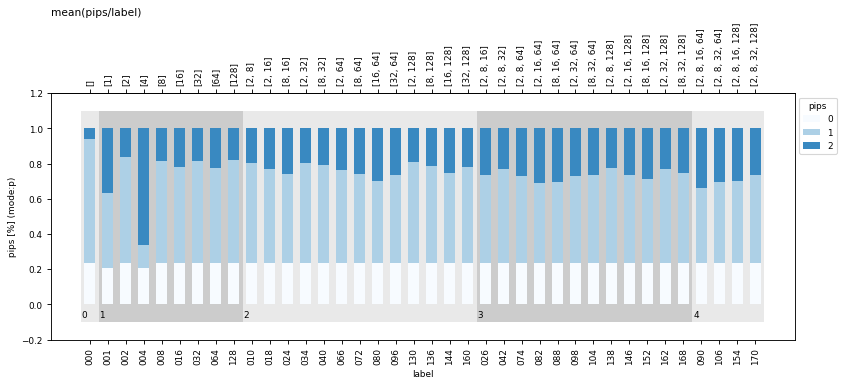

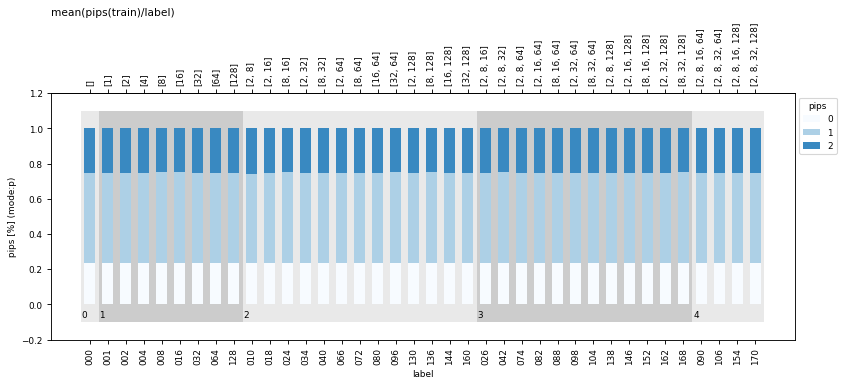

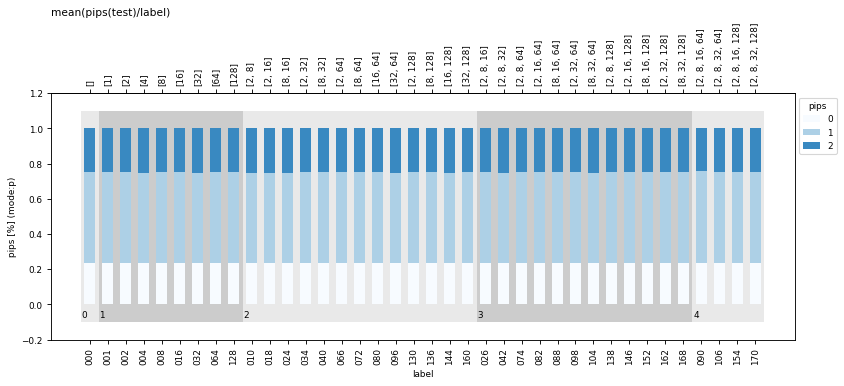

In [5]:

def plot_pips_(pips,mode="p",title=""):
    

    plt.rcParams["font.size"] = 8
    plt.rcParams["figure.dpi"] = 80

    nrows,ncols = 1,1

    fig, ax = plt.subplots(nrows=nrows,ncols=ncols,figsize=[12*ncols,4*nrows],dpi=plt.rcParams["figure.dpi"])

    size = pips.shape[0]
    xticks = np.arange(size)
    xticklabels = ["%03d"%(pips.loc[n,"number"]) for n in xticks]
    annotlabels = ["%s"%(pips.loc[n,"assembly"]) for n in xticks]

    bottom = [0]*size
    for c in pips_range:
        bottom = bottom + pips["%s%d"%(mode,c-1)] if c>0 else bottom
        height = pips["%s%d"%(mode,c)].to_numpy()
        ax.bar(xticks,height=height,bottom=bottom,label="%d"%(c),color=plt.cm.Blues(c*.33),width=0.6)
        
    ax.set_xticks(xticks)
    ax.set_xticklabels(xticklabels,rotation=90)

    sx = ax.secondary_xaxis("top",)
    sx.set_xticks(xticks,loc="top")
    sx.set_xticklabels(annotlabels,rotation=90)

    ax.legend(bbox_to_anchor=(1.,1),title="pips")
    ax.set_xlabel("label")
    ax.set_ylabel("pips [%%] (mode:%s)"%(mode))
    ax.set_ylim([-.2,1.2])

    ax.set_title("%s"%(title),x=0,ha="left")

    size = pips.groupby(by=["type"]).agg({"number":"count"}).to_dict()["number"]

    xy,h = [-.5,-.1],1.2
    a,z = .2,-1

    for k in size.keys():
        w = size[k]
        ax.add_patch(Rectangle(xy=xy,width=w,height=h,alpha=a,zorder=z,color=plt.cm.Greys(0.5*(k%2+1)),antialiased=False,linewidth=0))
        ax.annotate("%d"%(k),xy=(xy[0]+.04,xy[1]+.025))
        xy[0] = xy[0] + w

    f_savefig(os.path.join(fresult,"%s.label.pip.%s.png"%(fprefix,mode)),fmetadata,gshow=True)

plot_pips_(pips,mode="p",title="mean(pips/label)")
plot_pips_(pips_train,mode="p",title="mean(pips(train)/label)")
plot_pips_(pips_test,mode="p",title="mean(pips(test)/label)")

In [6]:

def plot_dies_(pips,mode,title=""):

    plt.rcParams["font.size"] = 8
    plt.rcParams["figure.dpi"] = 80

    nrows,ncols = 1,1
    nsize = 12,4

    fig, ax = plt.subplots(nrows=nrows,ncols=ncols,figsize=[nsize[0]*ncols,nsize[1]*nrows],dpi=plt.rcParams["figure.dpi"])

    size = pips.shape[0]
    xticks = np.arange(size)+1
    xticklabels = ["%03d"%(pips.loc[n-1,"number"]) for n in xticks]
    annotlabels = ["%s"%(pips.loc[n-1,"assembly"]) for n in xticks]

    nn = pips["number"]
    xx = [pips.loc[pips["number"]==n,mode].to_numpy()[0] for n in nn]

    props = dict(ms=2,lw=.5,color="red")

    rc = ax.boxplot(xx,patch_artist=True,notch=False,manage_ticks=False)

    for b in rc["boxes"]: 
        b.set_facecolor("skyblue")
        b.set_linewidth(.5)
    for m in rc["medians"]: 
        m.set_linewidth(.5)
    for w in rc["whiskers"]: 
        w.set_color("gray")
        w.set_linewidth(.5)
    for c in rc["caps"]: 
        c.set_color("gray")
        c.set_linewidth(.5)
    for f in rc["fliers"]:
        f.set_markeredgecolor("orangered")
        f.set_markeredgewidth(.5)
        f.set_marker("x")
        f.set_markersize(2)

    ax.set_xticks(xticks)
    ax.set_xticklabels(xticklabels,rotation=90)

    sx = ax.secondary_xaxis("top",)
    sx.set_xticks(xticks,loc="top")
    sx.set_xticklabels(annotlabels,rotation=90)

    ax.set_xlabel("label")
    ax.set_ylabel("dies")

    y_min = np.min([np.min(r) for r in pips[mode]])
    y_max = np.max([np.max(r) for r in pips[mode]])

    dy = (y_max-y_min) /2

    ax.set_ylim([y_min-dy,y_max+dy])

    ax.set_title("%s"%(title),x=0,ha="left")

    size = pips.groupby(by=["type"]).agg({"number":"count"}).to_dict()["number"]

    xy,h = [.5,y_min-dy/2],y_max-y_min + dy
    a,z = .2,-1

    for k in size.keys():
        w = size[k]
        ax.add_patch(Rectangle(xy=xy,width=w,height=h,alpha=a,zorder=z,color=plt.cm.Greys(0.5*(k%2+1)),antialiased=False,linewidth=0))
        ax.annotate("%d"%(k),xy=(xy[0],xy[1]))
        xy[0] = xy[0] + w

    f_savefig(os.path.join(fresult,"%s.label.die.%s.png"%(fprefix,mode)),fmetadata,gshow=True)



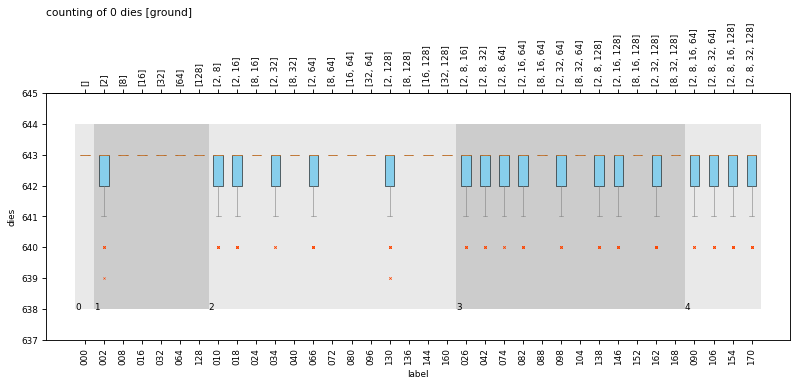

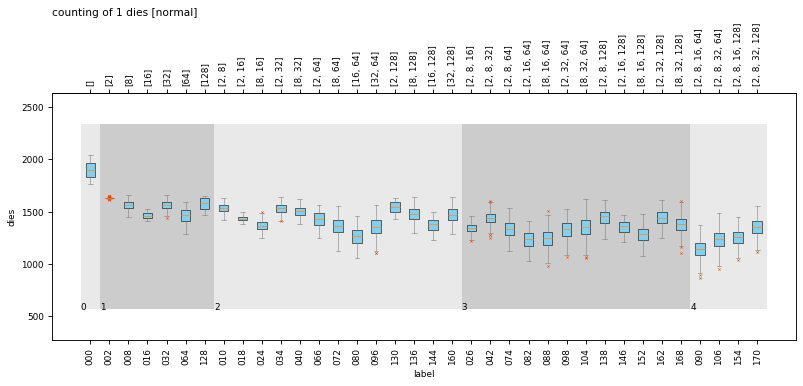

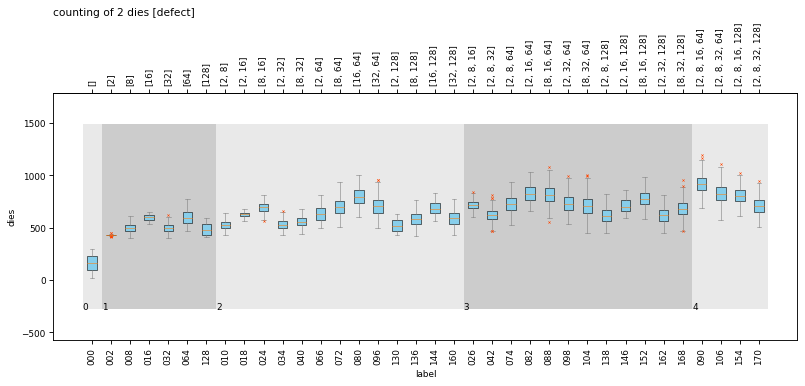

In [8]:
pips_ = pips.loc[~pips["number"].isin([1,4]),:].reset_index()

plot_dies_(pips_,"cc0",title="counting of 0 dies [ground]")
plot_dies_(pips_,"cc1",title="counting of 1 dies [normal]")
plot_dies_(pips_,"cc2",title="counting of 2 dies [defect]")

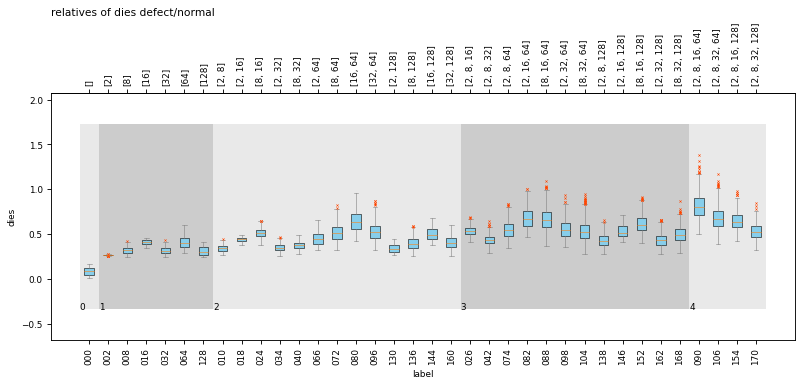

In [9]:
def c21_pips_(pips):

  c21 = []
  nn = pips["number"].to_numpy()
  for n in nn:
    cc = pips.loc[pips["number"]==n,["cc1","cc2"]].to_numpy()[0]  
    c21.append(cc[1]/cc[0])

  pips["c21"] = pd.DataFrame({"c21":c21}).apply(np.array)
  return pips

pips = c21_pips_(pips)

pips_ = pips.loc[~pips["number"].isin([1,4]),:].reset_index()
plot_dies_(pips_,"c21",title="relatives of dies defect/normal")

In [10]:
pips_train = c21_pips_(pips_train)
pips_test = c21_pips_(pips_test)


In [11]:
def c_generate_(yy):

    Q1,median,Q3 = np.percentile(yy,[25,50,75])
    IQR = Q3-Q1

    loval = Q1-1.5*IQR
    hival = Q3+1.5*IQR

    wiskhi = np.compress(yy<=hival,yy)
    wisklo = np.compress(yy>=loval,yy)
    actual_loval = np.min(wisklo)
    actual_hival = np.max(wiskhi)

    values = [Q1,median,Q3,loval,hival,actual_loval,actual_hival,IQR]
    keys = ["Q1","Median","Q3","Q1-1.5xIQR","Q3+1.5xIQR","Actual LO","Actual HI","IQR"]

    return {k:v for k,v in zip(keys,values)}

nn = pips["number"].to_numpy()
tt = pips["type"].to_numpy()

C = []

for n,t in zip(nn,tt):
    
    D_ = pips.loc[pips["number"]==n,"c21"].to_numpy()[0]
        
    C_ = c_generate_(D_)
    
    C_["number"] = n
    C_["type"] = t
    
    C.append(C_)

C = pd.DataFrame(C)

# classificator

C.to_pickle(os.path.join(fresult,"%s.boxes.die.pickle"%(fprefix)))
C

,Q1,Median,Q3,Q1-1.5xIQR,Q3+1.5xIQR,Actual LO,Actual HI,IQR,number,type
0,0.048855,0.084166,0.126845,-0.068131,0.243831,0.009799,0.169694,0.077990,0,0
1,0.681436,0.863319,1.118985,0.025112,1.775309,0.177089,1.769531,0.437549,1,1
2,0.262868,0.265807,0.268308,0.254708,0.276468,0.255021,0.275371,0.005440,2,1
3,3.162745,5.187320,8.480176,-4.813402,16.456323,2.037604,16.393701,5.317431,4,1
4,0.293785,0.318618,0.343546,0.219144,0.418188,0.243814,0.416495,0.049761,8,1
5,0.389751,0.412611,0.430257,0.328991,0.491016,0.349705,0.459632,0.040506,16,1
6,0.294598,0.316933,0.343546,0.221176,0.416969,0.244565,0.416495,0.048948,32,1
7,0.356591,0.402995,0.461702,0.198923,0.619370,0.292163,0.602644,0.105112,64,1
8,0.267528,0.301958,0.353472,0.138611,0.482390,0.247579,0.408749,0.085945,128,1
9,0.316042,0.342997,0.367618,0.238677,0.444982,0.267528,0.438241,0.051576,10,2


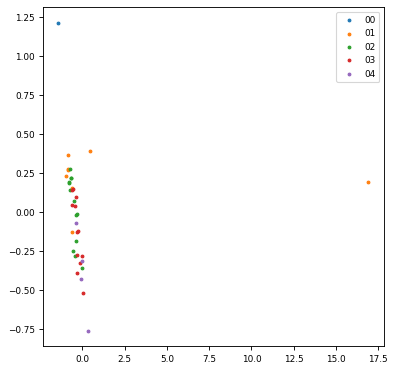

In [42]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

C_ = pd.DataFrame(scaler.fit_transform(C.loc[:,~C.columns.isin(["number","type"])]))

pca = PCA(n_components=2).fit(C_)
Cp = pca.transform(C_)

# ---------------------------

c_types = C["type"].unique()

plt.rcParams["font.size"] = 8
plt.rcParams["figure.dpi"] = 80

ncols,nrows = 1,1
nsize = 5.5,5.5

fig, ax = plt.subplots(nrows=nrows,ncols=ncols,figsize=[nsize[0]*ncols,nsize[1]*nrows],dpi=plt.rcParams["figure.dpi"])

for t in c_types:
    ii = np.argwhere(t==C["type"].to_numpy())
    ax.scatter(Cp[ii,0],Cp[ii,1],s=6,label="%02d"%(t))

ax.legend()

plt.show()
plt.close()

In [ ]:
C_ = C.loc[~C["number"].isin([1,4]),:].reset_index()

N = C_.shape[0]

cc = C_.columns
cc = cc[~cc.isin(["number","type","index"])]

AA = []
for c in cc:
    Y = C_[c].to_numpy()
    A = np.zeros((N,N))
    for y in range(N): A[y,:] = np.sqrt((Y-Y[y])**2)
    AA.append(A)

ticks = np.arange(A.shape[0])
ticklabels = C_["number"]

ncols,nrows = 4,2
nsize = 5.5,5.5

fig, ax = plt.subplots(nrows=nrows,ncols=ncols,figsize=[nsize[0]*ncols,nsize[1]*nrows],dpi=plt.rcParams["figure.dpi"])

plt.rcParams["font.size"] = 8
plt.rcParams["figure.dpi"] = 80

cmap = plt.cm.Reds

j,i,k = 0,0,0

for A in AA:
    
    ax[j,i].imshow(A,cmap=cmap)
    ax[j,i].set_title("%s"%(cc[k]),x=0,ha="left")

    ax[j,i].set_xticks(ticks)
    ax[j,i].set_xticklabels(ticklabels,rotation=90)
    ax[j,i].set_yticks(ticks)
    ax[j,i].set_yticklabels(ticklabels,rotation=0)

    i = i+1 if i+1<ncols else 0
    j = j+1 if i==0 else j
    k = k+1

plt.tight_layout(pad=2)
plt.show()
plt.close()


In [ ]:
# collect outlier/fliers indices

fliers = []
for n in nn:
    yy = pips.loc[pips["number"]==n,"c21"].to_numpy()[0]
    item_ = c_generate_(yy)
    flower,fupper = item_['Q1-1.5xIQR'],item_['Q3+1.5xIQR']
    ii = list(np.argwhere(yy<=flower).ravel()) + list(np.argwhere(yy>=fupper).ravel())
    fliers.append(
        dict(
            n=n,
            ii=ii,
            yy=yy
        ))

fliers = pd.DataFrame(fliers)

fliers

In [ ]:
plt.rcParams["font.size"] = 8
plt.rcParams["figure.dpi"] = 80

for j in range(fliers.shape[0]):

    flier = fliers.loc[j,:]

    nrows,ncols = 1,1
    nsize = 12,3

    fig, ax = plt.subplots(nrows=nrows,ncols=ncols,figsize=[nsize[0]*ncols,nsize[1]*nrows],dpi=plt.rcParams["figure.dpi"])

    rc = ax.boxplot(flier["yy"],
                patch_artist=False,
                notch=False,
                manage_ticks=True,
                vert=False,
                showfliers=True,flierprops=dict(marker='+',markeredgecolor="orangered",ms=10),
                )

    ax.set_yticklabels(["%03d"%(flier["n"])])

    ax.set_title("%03d [defect-normal-ratio] %d fliers"%(flier["n"],len(flier["ii"])),x=0,ha="left")

    plt.tight_layout()
    plt.show()
    plt.close()

In [ ]:
index = pips_.loc[pips_["number"]==n_number,"index"].to_numpy()[0]
n_index = index[findex]

# ---------------------------

def plot_samples_(n_index,mode="index",cmap=plt.cm.Blues):
    
    plt.rcParams["font.size"] = 8
    plt.rcParams["figure.dpi"] = 80

    n_cols = 8
    n_start = 0

    n_index = n_index if "index"==mode else pips_.loc[pips_["number"]==n_index,"index"].to_numpy()[0]
    n_bin = len(n_index) if "index"==mode else 2*n_cols

    n_rows = n_bin//n_cols + (1 if n_bin% n_cols != 0 else 0)
    
    n_width,n_height = 2,2
    fig,ax = plt.subplots(ncols=n_cols,nrows=n_rows,figsize=(n_width*n_cols,n_height*n_rows))

    if n_rows==1: ax = ax[np.newaxis,:]

    n_col = -1
    for i in range(n_start,n_start+n_bin):
        
        n_row = (i-n_start)//n_cols
        n_col = n_col+1 if n_col+1<n_cols else 0
        
        i_ = n_index[i]
        I = X_raw[i_,:,:]

        values,counts = np.unique(I,return_counts=True)
        
        ax[n_row,n_col].imshow(I,cmap=cmap)
        ax[n_row,n_col].set_title("%s"%(counts))
        
    for a in ax.ravel():
        a.set_axis_off()

    plt.tight_layout()
    plt.show()
    plt.close()

plot_samples_(n_index,cmap=plt.cm.Reds)
plot_samples_(n_index=n_number,mode="number")